we will use the metro interstate traffic volume dataset available on the UCI machine learning repository. The original dataset recorded
the hourly westbound traffic on I-94 between Minneapolis and St. Paul in Minnesota, from 2012 to 2018. For the purpose of learning how to apply deep learning for time series forecasting, the dataset has been shortened and cleaned to get rid of missing values. Our main
forecasting goal is to predict the hourly traffic volume.

In the case of multi-output models, we will also forecast the hourly temperature.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [13]:
url = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/metro_interstate_traffic_volume_preprocessed.csv'
df = pd.read_csv(url)
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


As mentioned, this dataset is a shortened and cleaned version of the original dataset available on the UCI machine learning repository. In this case, the dataset starts onSeptember 29, 2016, at 5 p.m. and ends on September 30, 2018, at 11 p.m.

In [14]:
df.shape

(17551, 6)

The features include the date and time, the temperature, the amount of rain and snow, the cloud coverage, as well as the traffic volume.

Now, let’s visualize the evolution of the traffic volume over time. Since our dataset is very large, with more than 17,000 records, we’ll plot only the first 400 data points, which is roughly equivalent to two weeks of data.

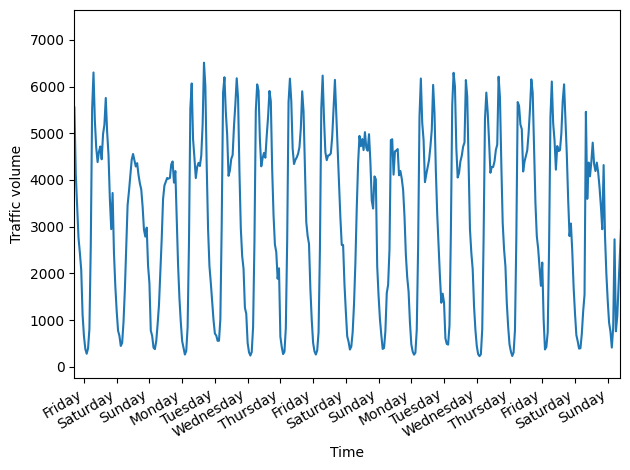

In [15]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday',
                                   'Monday', 'Tuesday', 'Wednesday', 
                                   'Thursday', 'Friday', 'Saturday',
                                   'Sunday', 'Monday', 'Tuesday', 
                                   'Wednesday', 'Thursday', 'Friday',
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

Notice clear daily seasonality, since the traffic volume is lower at the start and end of each day. You’ll also see a smaller traffic volume during the weekends. As for the trend, two weeks of data is likely insufficient to draw a reasonable conclusion.

We can also plot the hourly temperature, as it will be a target for our multioutput models. Let’s first visualize the hourly temperature over the entire dataset to see if we can identify any yearly seasonality.



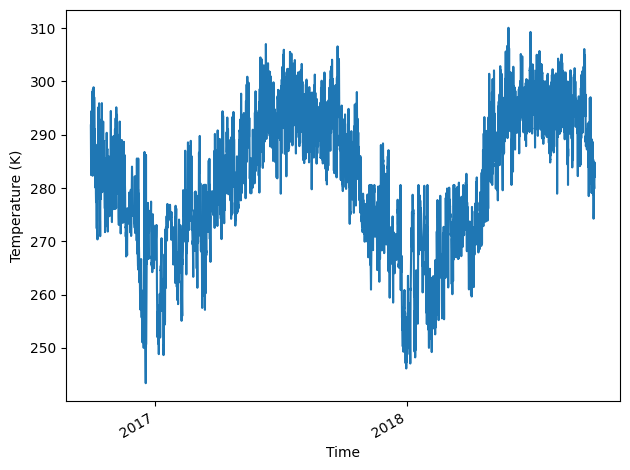

In [16]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
plt.xticks([2239, 10999], [2017, 2018])
fig.autofmt_xdate()
plt.tight_layout()

Hourly temperature (in Kelvin) from September 29, 2016, to September 30, 2018. Although there is noise, we can see a yearly seasonal pattern. higher in the middle of the year (summer). Thus, as expected, the temperature has yearly seasonality.

Now let’s verify whether we can observe daily seasonality in temperature.

(0.0, 400.0)

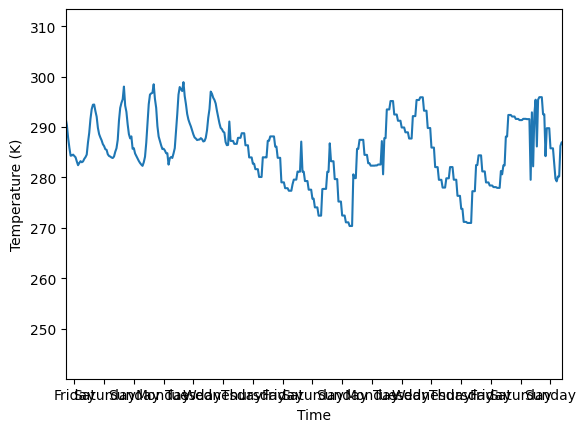

In [17]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 
                                   'Monday', 'Tuesday', 'Wednesday', 
                                   'Thursday', 'Friday', 'Saturday',
                                   'Sunday', 'Monday', 'Tuesday', 
                                   'Wednesday', 'Thursday', 'Friday',
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)

Hourly temperature (in Kelvin) starting on September 29, 2016, at 5 p.m. CST. Although it is a bit noisy, we can see that temperatures are indeed lower at the start and end of each day and peak during midday, suggesting daily seasonality.

## Feature engineering
In this section, we will study each feature and create new ones that will help our models forecast the traffic volume and hourly temperature. Finally, we’ll split the data and save each set as a CSV file for later use.

A great way to study the features of a dataset is to use the describe method from pandas. This method returns the number of records for each feature, allowing us to quickly identify missing values, the mean, standard deviation, quartiles, and maximum and minimum values for each feature.

In [19]:
# The transpose method puts each feature on its own row.
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


rain_1h is mostly 0 throughout the dataset, as its third quartile is still at 0. Since at least 75% of the values for rain_1h are 0, it is unlikely that it is a strong predictor of traffic volume. Thus, this feature will be removed.

Looking at snow_1h, you’ll notice that this variable is at 0 through the entire dataset. This is easily observable, since its minimum and maximum values are both 0. Thus, this is not predictive of the variation in traffic volume over time. This feature will also be removed from the dataset.

In [21]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

Rhe date_time feature is not usable by our models, since it is a datetime string. We will convert it into a numerical value. A simple way to do that is to express the date as a number of seconds. This is achieved through the use of the timestamp method from the datetime library.

In [24]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

Unfortunately, we are not done, as this simply expresses each date in seconds, as shown in the following figure. This leads us to losing the cyclical nature of time, because the number of seconds simply increases linearly with time. 

Therefore, we must apply a transformation to recover the cyclical behavior of time. A simple way to do that is to apply a sine transformation.

The timestamp is in seconds, so we must calculate the number of seconds in a day before applying the sine transformation.

In [25]:
day = 24 * 60 * 60
# Application of the sine transformation. We use radians in the sine function.
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values

With a single sine transformation, we regain some of the cyclical property that was lost when converting to seconds. However, at this point, 12 p.m. is equivalent to 12 a.m., and 5 p.m. is equivalent to 5 a.m. This is undesired, as we want to distinguish between
morning and afternoon. We’ll apply a cosine transformation. We know that cosine is out of phase with the sine function. This allows us to distinguish between. 5 a.m. and 5 p.m., expressing the cyclical nature of time in a day. At this point, we can remove the date_time column from the DataFrame.

In [26]:
# Apply the cosine transformation to the timestamp in seconds.
df['day_cos'] = (np.cos(timestamp_s * (2 * np.pi/day))).values

# Remove the date_time column.
df = df.drop(['date_time'], axis=1)

We can quickly convince ourselves that these transformations worked by plotting a sample of day_sin and day_cos. The points form a circle, just like a clock.

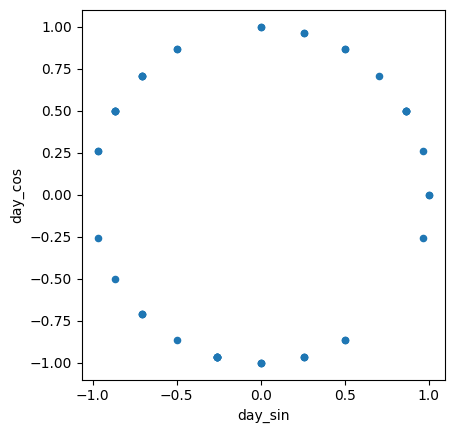

In [27]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');

## Split data

Here we’ll use a simple 70:20:10 split for the train, validation, and test sets. While 10% of the data seems like a small portion for the test set

In [28]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

## Sccaler data

We must scale it so all values are between 0 and 1. This decreases the time required for training deep learning models, and it improves their performance. We’ll use MinMaxScaler from sklearn to scale our data. In the case of deep learning, no assumptions are made, so normalizing is not required.